# Generate trip profiles with SimBEV

In [1]:
# import packages
import os
import sys
import configparser as cp
import numpy as np
import pandas as pd

from pathlib import Path
from datetime import datetime

# get simbev directory
parent_dir = Path(os.getcwd()).parent
simbev_dir = parent_dir / 'simbev'

# add the paths of scripts you want to import as SimBEV is not available as package yet
sys.path.insert(0, str(simbev_dir))

# import SimBEV
import simbevMiD as sb

# import SimBEV helpers functions
from helpers.helpers import single_to_multi_scenario

In [2]:
# set standard variables
scenario = 'default_single'

scenario_dir = os.path.join(simbev_dir, 'scenarios', scenario)

In [3]:
# read the config file
# this file holds the number of cars and other simulation parameters
cfg = cp.ConfigParser()

cfg_file = os.path.join(scenario_dir, 'simbev_config.cfg')
cfg.read(cfg_file)

['/home/kilian/Documents/git/github/simbev/simbev/scenarios/default_single/simbev_config.cfg']

In [4]:
# get simulation parameters from config file
# get timestep (in minutes). Default is 15
stepsize = cfg.getint('basic', 'stepsize')

# get days for simulation. Default is 14 (2 Weeks)
days = cfg.getint('basic', 'days')

# get minimum soc value in %. Determines at which point
# a car needs to be charged per HPC. Default is 0.2 (20%)
soc_min = cfg.getfloat('basic', 'soc_min')

# set random seed from config or truly random if none is given
rng_seed = cfg['sim_params'].getint('seed', None)

# get the region mode (single or multi). Default 'single'
region_mode = cfg.get('region_mode', 'region_mode')

In [5]:
# get region parameters
if region_mode == 'single':
    regions, tech_data = single_to_multi_scenario(
        region_type=cfg.get('basic', 'regio_type'),
        rampup=dict(cfg['rampup_ev']),
        max_charging_capacity_slow=dict(cfg['tech_data_cc_slow']),
        max_charging_capacity_fast=dict(cfg['tech_data_cc_fast']),
        battery_capacity=dict(cfg['tech_data_bc']),
        energy_consumption=dict(cfg['tech_data_ec'])
    )
elif region_mode == 'multi':
    # load region data
    regions = pd.read_csv(os.path.join(scenario_path, cfg.get('rampup_ev', 'rampup'))).set_index('region_id')
    tech_data = pd.read_csv(os.path.join(scenario_path, cfg.get('tech_data', 'tech_data'))).set_index('type')

In [6]:
regions

,RegioStaR7,bev_mini,bev_medium,bev_luxury,phev_mini,phev_medium,phev_luxury
region_id,,,,,,,
single_region,LR_Klein,10,10,1,0,0,0


In [7]:
tech_data

,max_charging_capacity_slow,max_charging_capacity_fast,battery_capacity,energy_consumption
type,,,,
bev_mini,11.0,50.0,30.0,0.13
bev_medium,22.0,50.0,65.0,0.16
bev_luxury,50.0,150.0,90.0,0.20
phev_mini,3.7,0.0,20.0,0.16
phev_medium,11.0,0.0,20.0,0.16
phev_luxury,11.0,0.0,20.0,0.16


In [8]:
# initialize numpy random generator
rng = np.random.default_rng(seed=rng_seed)

In [9]:
# read in charging point probabilities
# AC
charge_prob_slow = pd.read_csv(
    os.path.join(scenario_dir, cfg['charging_probabilities']['slow']), index_col=[0])
# DC
charge_prob_fast = pd.read_csv(
    os.path.join(scenario_dir, cfg['charging_probabilities']['fast']), index_col=[0])

In [10]:
# create results directroy
main_results_dir = 'res'
main_results_dir = Path(main_results_dir)

# create sub results dir for current run
sub_dir = f'{scenario}_{datetime.now().strftime("%Y-%m-%d")}_simbev_run'

# join paths
results_dir = main_results_dir.joinpath(sub_dir)

# make dir
os.makedirs(results_dir, exist_ok=True)

In [11]:
# init charging demand df
ca = {
    "location": "init",
    "SoC": 0,
    "chargingdemand": 0,
    "charge_time": 0,
    "charge_start": 0,
    "charge_end": 0,
    "netto_charging_capacity": 0,
    "consumption": 0,
    "drive_start": 0,
    "drive_end": 0,
}

columns = [
    "location",
    "SoC",
    "chargingdemand",
    "charge_time",
    "charge_start",
    "charge_end",
    "netto_charging_capacity",
    "consumption",
    "drive_start",
    "drive_end",
]

charging_all = pd.DataFrame(
    data=ca,
    columns=columns,
    index=[0],
)

In [12]:
# get car types
car_type_list = sorted([col for col in regions.columns if col != 'RegioStaR7'])

In [13]:
# run for each region
for region_ctr, (region_id, region_data) in enumerate(regions.iterrows()):
    print(f'===== Region: {region_id} ({region_ctr+1}/{len(regions)}) =====')

    # get probabilities
    probdata, wd = sb.get_prob(
        region_data.RegioStaR7,
        stepsize,
    )
    
    # get number of cars
    numcar_list = list(region_data[car_type_list])

    # SOC init value for the first monday
    SoC_init = [
        rng.random() ** (1 / 3) * 0.8 + 0.2 if rng.random() < 0.12 else 1
        for _ in range(sum(numcar_list))
    ]
    count_cars = 0

    # loop for types of cars
    for idx, car_type_name in enumerate(car_type_list):
        tech_data_car = tech_data.loc[car_type_name]
        numcar = numcar_list[idx]

        if "bev" in car_type_name:
            car_type = "BEV"
        else:
            car_type = "PHEV"

        # loop for number of cars
        for icar in range(numcar):
            print("\r{}% {} {} / {}".format(
                round((count_cars + 1) * 100 / sum(numcar_list)),
                car_type_name,
                (icar + 1), numcar
            ), end="", flush=True)
            charging_car = pd.DataFrame(
                data=ca,
                columns=columns,
                index=[0],
            )
            # print(icar)
            # indices to ensure home and work charging capacity does not alternate
            idx_home = 0
            idx_work = 0
            home_charging_capacity = 0
            work_charging_capacity = 0

            # init data for car status
            range_day = int(1440 / stepsize)
            carstatus = np.zeros(int(range_day / 2))
            carstatus[:int(range_day / 4)] = 2
            car_data = {
                "place": "6_home",
                "status": carstatus,
                "distance": 0,
            }

            # init availability df
            a = {
                "status": 0,
                "location": "init",
                "distance": 0,
            }
            availability = pd.DataFrame(
                data=a,
                columns=[
                    "status",
                    "location",
                    "distance",
                ],
                index=[0],
            )

            soc_start = SoC_init[count_cars]

            last_charging_capacity = min(
                sb.slow_charging_capacity(
                    charge_prob_slow,
                    '6_home',
                    rng,
                ),
                tech_data_car.max_charging_capacity_slow,
            ) * cfg.getfloat('basic', 'eta_cp')

            # loop for days of the week
            for key in wd:
                # create availability timeseries and charging times
                (av, car_data, demand,
                 soc_start, idx_home,
                 idx_work, home_charging_capacity,
                 work_charging_capacity) = sb.availability(
                    car_data,
                    key,
                    probdata,
                    stepsize,
                    tech_data_car.battery_capacity,
                    tech_data_car.energy_consumption,
                    tech_data_car.max_charging_capacity_slow,
                    tech_data_car.max_charging_capacity_fast,
                    soc_start,
                    car_type,
                    charge_prob_slow,
                    charge_prob_fast,
                    idx_home,
                    idx_work,
                    home_charging_capacity,
                    work_charging_capacity,
                    last_charging_capacity,
                    rng,
                    cfg.getfloat('basic','eta_cp'),
                    soc_min,
                )
                # add results for this day to availability timeseries
                availability = availability.append(av).reset_index(drop=True)

                # print("Auto Nr. " + str(count) + " / " + str(icar))
                # print(str(home_charging_capacity) + " kW")
                # print(demand.loc[demand.location == "6_home"].netto_charging_capacity)

                # add results for this day to demand time series
                charging_all = charging_all.append(demand)

                # add results for this day to demand time series for a single car
                charging_car = charging_car.append(demand)
                # print(key, charging_car)

                last_charging_capacity = charging_car.netto_charging_capacity.iat[-1]
                # print("car" + str(icar) + "done")
                
            # clean up charging_car

            # drop init row of availability df
            availability = availability.iloc[1:]
            # save availability df
            # availability.to_csv("res/availability_car" + str(icar) + ".csv")

            region_path = results_dir.joinpath(str(region_id))
            region_path.mkdir(exist_ok=True)

            # Export timeseries for each car
            sb.charging_flexibility(
                charging_car,
                car_type_name,
                icar,
                stepsize,
                len(wd),
                tech_data_car.battery_capacity,
                rng,
                cfg.getfloat('basic','eta_cp'),
                region_path,
            )

            count_cars += 1
        if numcar >= 1:
            print(" - done")

===== Region: single_region (1/1) =====
5% bev_luxury 1 / 1 - done
52% bev_medium 10 / 10 - done
100% bev_mini 10 / 10 - done


# Evaluate Trip Profiles

In [14]:
# imports for plotting
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [15]:
# get generated file names
files_dir = os.path.join(results_dir, 'single_region')

files = os.listdir(files_dir)

files.sort()

cars_dict = {}

# get generated car data
for f in files:
    # get key name
    string_parts = f.split('_')
    key = '_'.join(string_parts[:3])
    
    # get data
    cars_dict[key] = pd.read_csv(os.path.join(files_dir, f), index_col=[0])

In [16]:
cars_dict[key].head()

,car_type,bat_cap,location,netto_charging_capacity,SoC_start,SoC_end,chargingdemand,charge_time,park_start,park_end,drive_start,drive_end,consumption
0,bev_mini,30,6_home,11.0,0.000000,1.000000,0.0,25,1,25,0,0,0.000000
1,bev_mini,30,driving,0.0,1.000000,0.922717,0.0,0,0,0,26,34,2.318498
2,bev_mini,30,0_work,0.0,0.922717,0.922717,0.0,0,35,68,0,0,0.000000
3,bev_mini,30,driving,0.0,0.922717,0.863447,0.0,0,0,0,69,71,1.778094
4,bev_mini,30,3_shopping,11.0,0.863447,0.863447,0.0,0,72,73,0,0,0.000000


## Annual Mileage

In [17]:
# get energy consumption in kWh/km per car type
mean_energy_consumption_dict = dict(cfg['tech_data_ec'])

annual_mileage_list = []

# calculate annual mileage
for key, car_df in cars_dict.items():
    # get mean energy consumption
    car_type = car_df.car_type.iat[0]
    
    mean_energy_consumption = float(mean_energy_consumption_dict[car_type])
    
    # get total energy consumption (2 weeks)
    total_energy_consumption = car_df.consumption.sum()
    
    # calc annual mileage
    factor = 365 / days # 2 weeks -> year
    annual_mileage = factor*total_energy_consumption / mean_energy_consumption
    
    annual_mileage_list.append(annual_mileage)


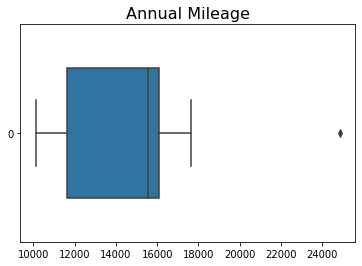

In [18]:
# generate boxplot
ax = sns.boxplot(data=annual_mileage_list, orient="h", width=0.6)
ax.set_title("Annual Mileage", fontsize=16)

plt.show()

## Concurrent Parking

In [19]:
# initialize data frame
parking_df = pd.DataFrame(
    data=0,
    columns=["home", "work", "public"],
    index=pd.date_range(start="2021-01-01", periods=days*24*4, freq="15min"),
)

# calculate concurrent parking
for key, car_df in cars_dict.items():
    car_parking_df = car_df.loc[car_df.park_start != 0]
    
    for location in parking_df.columns:
        if location == "home":
            location_df = car_parking_df.loc[car_parking_df.location == "6_home"]
        elif location == "work":
            location_df = car_parking_df.loc[car_parking_df.location == "0_work"]
        else:
            location_df = car_parking_df.loc[~car_parking_df.location.isin(["6_home", "0_work"])]
    
        for idx, row in location_df.iterrows():
            parking_df[location].iloc[row["park_start"]-1:row["park_end"]] += 1
            

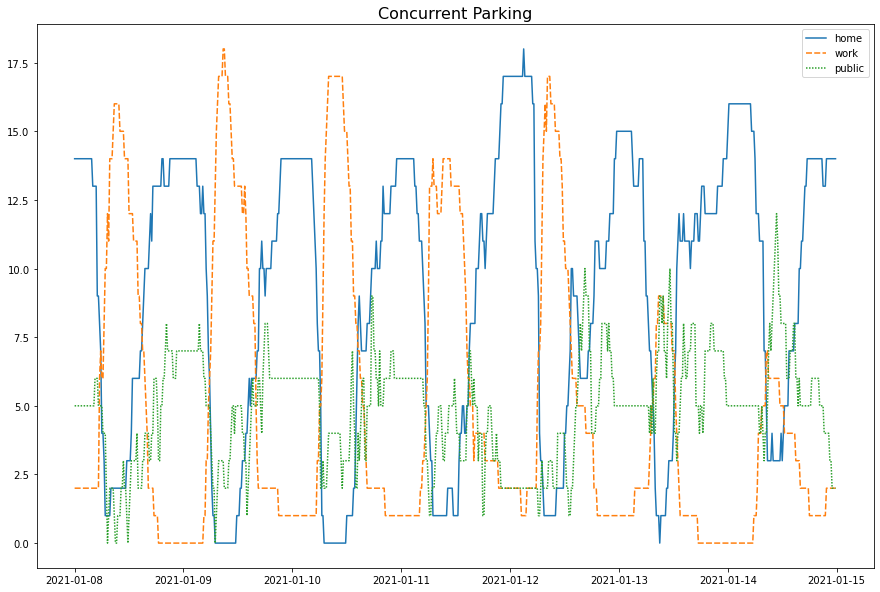

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))

sns.lineplot(data=parking_df.loc["2021-01-08":], ax=ax)

ax.set_title("Concurrent Parking", fontsize=16)

plt.show()

## Concurrent Parking with Charging Processes

In [21]:
# initialize data frame
charging_df = pd.DataFrame(
    data=0,
    columns=["home", "work", "public"],
    index=pd.date_range(start="2021-01-01", periods=days*24*4, freq="15min"),
)

# calculate concurrent charging times with charging processes
for key, car_df in cars_dict.items():
    car_charging_df = car_df.loc[car_df.chargingdemand > 0]
        
    for location in charging_df.columns:
        if location == "home":
            location_df = car_charging_df.loc[car_charging_df.location == "6_home"]
        elif location == "work":
            location_df = car_charging_df.loc[car_charging_df.location == "0_work"]
        else:
            location_df = car_charging_df.loc[~car_charging_df.location.isin(["6_home", "0_work"])]
    
        for idx, row in location_df.iterrows():
            charging_df[location].iloc[row["park_start"]-1:row["park_end"]] += 1
            

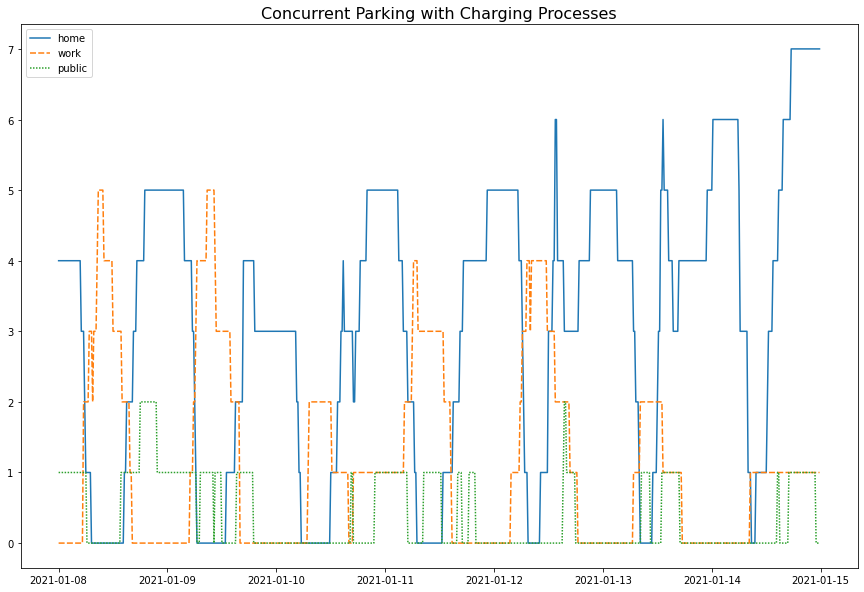

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))

sns.lineplot(data=charging_df.loc["2021-01-08":], ax=ax)

ax.set_title("Concurrent Parking with Charging Processes", fontsize=16)

plt.show()